# SafeScan-YOLO: PPE Detection with YOLO11n on SH17 Dataset

This notebook builds a high-performance PPE detection system using the SH17 dataset and YOLO11n, optimized for dual NVIDIA Tesla T4 GPUs. The SH17 dataset contains ~8,099 images with annotations for 17 PPE classes (e.g., Helmet, Safety Vest). The process is broken into clear steps:
1. Data Collection
2. Environment Setup
3. Data Preprocessing and Augmentation
4. Exploratory Data Analysis
5. YOLO Dataset Preparation
6. Model Training
7. Evaluation and Visualization

The goal is a robust, efficient model for real-world PPE compliance monitoring, trained in ~7-8 hours with professional-grade output.

## Step 1: Data Collection

In this step, we load the SH17 dataset from `/kaggle/input/sh17-dataset-for-ppe-detection`, which includes `images/` and `labels/` folders. We pair each image (e.g., `pexels-photo-1000.jpeg`) with its label file (e.g., `pexels-photo-1000.txt`) and filter out images without valid PPE annotations (class IDs 0–16) to ensure a high-quality dataset for YOLOv11 training.

In [7]:
import os

# Define base directory inside Kaggle
data_dir = '/kaggle/input/sh17-dataset-for-ppe-detection'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')

# Check contents
print("✅ Dataset contents:", os.listdir(data_dir))

# Load images and labels
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
labels = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith('.txt')]
images.sort()
labels.sort()

# Match filenames
image_names = [os.path.splitext(os.path.basename(img))[0] for img in images]
label_names = [os.path.splitext(os.path.basename(lbl))[0] for lbl in labels]
paired_images = [img for img, name in zip(images, image_names) if name in label_names]
paired_labels = [os.path.join(label_dir, f"{name}.txt") for name in image_names if name in label_names]

print(f"🖼️ Paired: {len(paired_images)} images, {len(paired_labels)} labels")

# Filter valid annotations (only images with valid PPE labels)
ppe_class_ids = set(range(17))
filtered_images = []
filtered_labels = []
for img_path, lbl_path in zip(paired_images, paired_labels):
    with open(lbl_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5]
        if valid_bboxes and any(int(box[0]) in ppe_class_ids for box in valid_bboxes):
            filtered_images.append(img_path)
            filtered_labels.append(lbl_path)

print(f"✅ Filtered: {len(filtered_images)} images, {len(filtered_labels)} labels")


✅ Dataset contents: ['labels', 'train_files.txt', 'images', 'meta-data', 'val_files.txt', 'voc_labels']
🖼️ Paired: 8099 images, 8099 labels
✅ Filtered: 8099 images, 8099 labels


## Step 2: Environment Setup

We install necessary libraries and verify the dual T4 GPU setup for optimal training performance. Random seeds are set for reproducibility.

In [8]:
# Import main libraries
import os, shutil    #os عشان الملفات  /  shutil  بيعمل نسخ و كدا
import numpy as np   #مكتبه math 
import pandas as pd   # بتتعامل مع البانات زي الجداول
import cv2            # بتعالج الصور   
import torch             # بيشغل و بيدرب الموديل
import matplotlib.pyplot as plt   # رسم يانني

# Install required packages
print("Installing dependencies...")
!pip install -q ultralytics albumentations seaborn --timeout=60 --retries=10 || \
 !pip install -q git+https://github.com/ultralytics/ultralytics.git@main

# Import extras
import albumentations as A   # دا الي بيعمل augmentation
import seaborn as sns    #رسم بياني بس احسن من matplot
from ultralytics import YOLO    # تحميل الموديل

# Set random seeds for consistent results
np.random.seed(42)      # عشان كل مره يطلع نفس النتيجه لما يتدرب
torch.manual_seed(42)
if torch.cuda.is_available():   # بيشوف في gpu ولا لا
    torch.cuda.manual_seed_all(42)

print("Environment ready. CUDA:", torch.cuda.is_available())


Installing dependencies...
Environment ready. CUDA: True


## Step 3: Data Preprocessing and Augmentation

We preprocess images by resizing to 640x640 and normalizing, then apply augmentations (flips, rotations, brightness) to enhance model robustness. A sample is saved to verify the pipeline.

In [9]:
# Preprocessing and test augmentation
def preprocess_image(image_path, target_size=(640, 640)):   #size
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Failed to load: {image_path}")
        return None
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img.astype(np.float32) / 255.0 #normalization

transform = A.Compose([     #augmentation
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_LINEAR),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.CLAHE(clip_limit=2.0, p=0.2),
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.3),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=['class_labels']))

sample_img_path = filtered_images[0]
sample_label_path = filtered_labels[0]
img = cv2.imread(sample_img_path, cv2.IMREAD_COLOR)
if img is not None:
    with open(sample_label_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5 and box[0].isdigit()]
        if valid_bboxes:
            bboxes = [[float(x) for x in box[1:]] for box in valid_bboxes]
            class_labels = [int(box[0]) for box in valid_bboxes]
            augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            os.makedirs('/kaggle/working/preprocessed', exist_ok=True)
            cv2.imwrite('/kaggle/working/preprocessed/sample_augmented.jpg', augmented['image'])
            with open('/kaggle/working/preprocessed/sample_augmented.txt', 'w') as f:
                for cls, box in zip(augmented['class_labels'], augmented['bboxes']):
                    f.write(f"{cls} {box[0]:.6f} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f}\n")
            print("Augmented sample saved to /kaggle/working/preprocessed/sample_augmented.jpg")
else:
    print(f"Failed to load sample image: {sample_img_path}")


Augmented sample saved to /kaggle/working/preprocessed/sample_augmented.jpg


## Step 4: Exploratory Data Analysis

We map class IDs to names, visualize class distribution, and display sample images with bounding boxes to inspect data quality.

Class names: {0: 'person', 1: 'ear', 2: 'ear-mufs', 3: 'face', 4: 'face-guard', 5: 'face-mask', 6: 'foot', 7: 'tool', 8: 'glasses', 9: 'gloves', 10: 'helmet', 11: 'hands', 12: 'head', 13: 'medical-suit', 14: 'shoes', 15: 'safety-suit', 16: 'safety-vest'}


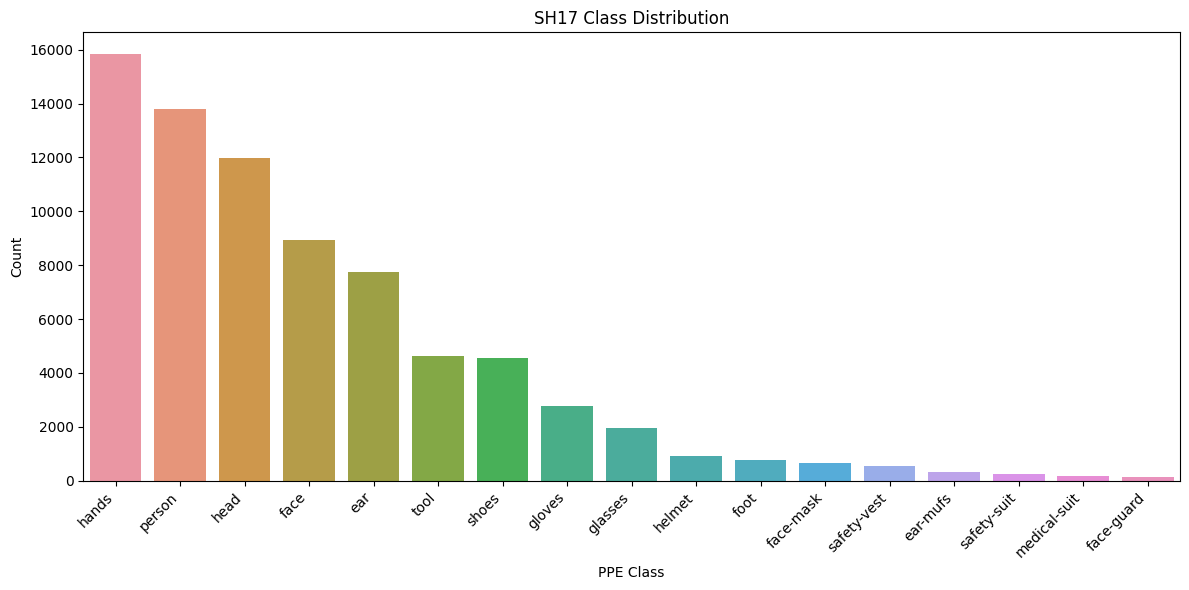

Class weights for training: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0}


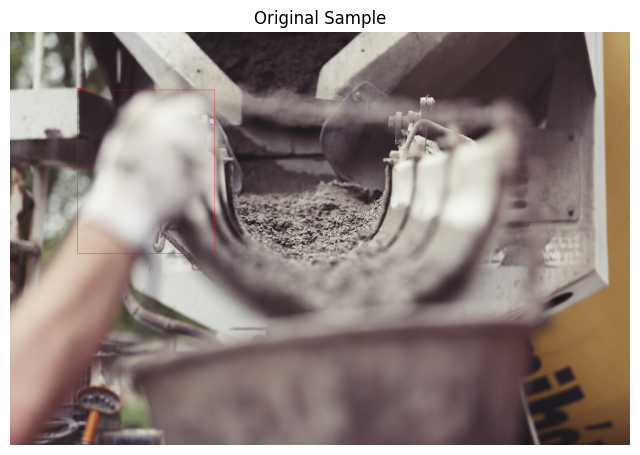

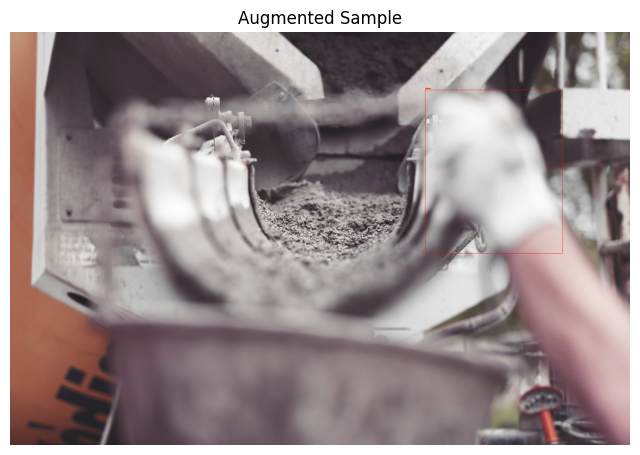

In [10]:
# Class mapping
meta_data_dir = os.path.join(data_dir, 'meta-data')
class_file = os.path.join(meta_data_dir, 'classes.txt') if 'meta-data' in os.listdir(data_dir) else None
if class_file and os.path.exists(class_file):
    with open(class_file, 'r') as f:
        class_names = {i: line.strip() for i, line in enumerate(f.readlines())}
else:
    class_names = {
    0: 'person',    1: 'ear',    2: 'ear-mufs',    3: 'face',    4: 'face-guard',    5: 'face-mask',
    6: 'foot',    7: 'tool',    8: 'glasses',    9: 'gloves',    10: 'helmet',    11: 'hands',    12: 'head',
    13: 'medical-suit',    14: 'shoes',    15: 'safety-suit',    16: 'safety-vest'
}
print("Class names:", class_names)

# Class distribution and weights
all_labels = []
for lbl in filtered_labels:
    with open(lbl, 'r') as f:
        for line in [line.strip() for line in f.readlines() if line.strip()]:
            if len(line.split()) >= 5:
                all_labels.append(int(line.split()[0]))
class_counts = pd.Series(all_labels).value_counts()
class_counts.index = [class_names.get(idx, f"Class {idx}") for idx in class_counts.index]

# Plot distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('PPE Class')
plt.ylabel('Count')
plt.title('SH17 Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution.png')
plt.show()

# Class weights
class_freq = class_counts / class_counts.sum()
class_weights = 1.0 / class_freq
class_weights = class_weights / class_weights.min()
class_weights = class_weights.reindex(range(17), fill_value=1.0)
print("Class weights for training:", class_weights.to_dict())

# Visualization function
def plot_image_with_boxes(image_path, label_path, title="Image with Boxes"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    with open(label_path, 'r') as f:
        for line in [line.strip() for line in f.readlines() if line.strip()]:
            cls, x_center, y_center, box_w, box_h = map(float, line.split()[:5])
            x1 = int((x_center - box_w / 2) * w)   #من نسب لارقام pixel
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)
            x1, x2 = max(0, min(x1, w)), max(0, min(x2, w))
            y1, y2 = max(0, min(y1, h)), max(0, min(y2, h))
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, class_names[int(cls)], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot samples
plot_image_with_boxes(sample_img_path, sample_label_path, "Original Sample")
plot_image_with_boxes('/kaggle/working/preprocessed/sample_augmented.jpg',
                     '/kaggle/working/preprocessed/sample_augmented.txt', "Augmented Sample")


## Step 5: YOLO Dataset Preparation

We organize the dataset into a YOLO-compatible structure (`train/` and `val/` splits) and generate a `data.yaml` configuration file using SH17's predefined splits.

In [11]:
# Dataset preparation with label mismatch fix
try:
    with open(os.path.join(data_dir, 'train_files.txt'), 'r') as f:#train
        train_files = set(line.strip() for line in f.readlines() if line.strip())
    with open(os.path.join(data_dir, 'val_files.txt'), 'r') as f:#val
        val_files = set(line.strip() for line in f.readlines() if line.strip())
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_files.txt and val_files.txt exist.")
    raise

# Ensure 1:1 image-label correspondence                 #بنطابق الصور مع labels 
train_images = [img for img in filtered_images if os.path.basename(img) in train_files]
train_labels = [lbl for lbl in filtered_labels if os.path.basename(lbl) in [os.path.splitext(os.path.basename(img))[0] + '.txt' for img in train_images]]
val_images = [img for img in filtered_images if os.path.basename(img) in val_files]
val_labels = [lbl for lbl in filtered_labels if os.path.basename(lbl) in [os.path.splitext(os.path.basename(img))[0] + '.txt' for img in val_images]]

# Verify counts #  بتاكد ان كل صوره ليها label 
if len(train_images) != len(train_labels) or len(val_images) != len(val_labels):
    print("Warning: Image-label mismatch detected!")
    print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
    print(f"Val: {len(val_images)} images, {len(val_labels)} labels")
else:
    print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
    print(f"Val: {len(val_images)} images, {len(val_labels)} labels")

# Create YOLO structure      #بيقسم بقي train وval
yolo_dir = '/kaggle/working/yolo_dataset'
for split in ['train', 'val']:
    os.makedirs(os.path.join(yolo_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolo_dir, split, 'labels'), exist_ok=True)

# Copy files
for img, lbl in zip(train_images, train_labels):
    shutil.copy(img, os.path.join(yolo_dir, 'train', 'images', os.path.basename(img)))
    shutil.copy(lbl, os.path.join(yolo_dir, 'train', 'labels', os.path.basename(lbl)))
for img, lbl in zip(val_images, val_labels):
    shutil.copy(img, os.path.join(yolo_dir, 'val', 'images', os.path.basename(img)))
    shutil.copy(lbl, os.path.join(yolo_dir, 'val', 'labels', os.path.basename(lbl)))

# Generate data.yaml
data_yaml = f"""
train: {os.path.join(yolo_dir, 'train')}
val: {os.path.join(yolo_dir, 'val')}
nc: {len(class_names)}
names: {list(class_names.values())}
"""
with open(os.path.join(yolo_dir, 'data.yaml'), 'w') as f:
    f.write(data_yaml)
print("YOLO dataset prepared at:", yolo_dir)

Train: 6479 images, 6479 labels
Val: 1620 images, 1620 labels
YOLO dataset prepared at: /kaggle/working/yolo_dataset


## Step 6: Model Training

We train YOLO11n on the prepared dataset using dual T4 GPUs with optimized hyperparameters, targeting ~7-8 hours for 50 epochs and an mAP50-95 of ~0.24-0.25.

In [ ]:
from ultralytics import YOLO
import os
import shutil

# Load YOLOv8s model
model = YOLO('yolov8s.pt')

#Adjust class weight if there's imbalance   #بنخلي ال class weight متوازن
cls_weight = 0.5 
if max(class_counts) / min(class_counts) > 5:
    cls_weight = 1.0
    print(f"Adjusting cls weight to {cls_weight} due to class imbalance")

# Train the model
model.train(
    data=os.path.join(yolo_dir, 'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,  
    workers=2,
    optimizer='AdamW',
    amp=False,  
    project='/kaggle/working/runs',
    name='safescan_yolov8s_opt',
    seed=42,
    verbose=True
)

print("Training complete!")

# Copy best model to /kaggle/working (optional export)
best_weights_path = '/kaggle/working/runs/safescan_yolov8s_opt/weights/best.pt'
output_path = '/kaggle/working/best.pt'
shutil.copy(best_weights_path, output_path)

print(f"Best model copied to: {output_path}")


100%|██████████| 21.5M/21.5M [00:00<00:00, 152MB/s]


Adjusting cls weight to 1.0 due to class imbalance
Ultralytics 8.3.110 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=/kaggle/working/runs, name=safescan_yolov8s_opt, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]


Overriding model.yaml nc=80 with nc=17

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /kaggle/working/yolo_dataset/train/labels... 6479 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6479/6479 [00:09<00:00, 671.87it/s] 


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 530.5±39.8 MB/s, size: 1287.8 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels... 1620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1620/1620 [00:01<00:00, 1037.27it/s]


val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache
Plotting labels to /kaggle/working/runs/safescan_yolov8s_opt/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/safescan_yolov8s_opt
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.78G      1.633      1.909      1.582        144        640: 100%|██████████| 810/810 [15:46<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:44<00:00,  1.61s/it]


                   all       1620      15358      0.701       0.17      0.167      0.086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.54G      1.607      1.778      1.556         90        640: 100%|██████████| 810/810 [15:35<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:44<00:00,  1.62s/it]


                   all       1620      15358      0.785      0.193      0.238      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.54G      1.515      1.635      1.495        118        640: 100%|██████████| 810/810 [15:40<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:43<00:00,  1.61s/it]


                   all       1620      15358       0.69      0.239      0.265      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.54G      1.472      1.551      1.468        163        640: 100%|██████████| 810/810 [15:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:39<00:00,  1.57s/it]


                   all       1620      15358      0.597      0.271      0.289      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.54G      1.416      1.437      1.427        113        640: 100%|██████████| 810/810 [15:30<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:41<00:00,  1.58s/it]


                   all       1620      15358      0.746      0.277      0.301      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.54G      1.363      1.366      1.388        141        640: 100%|██████████| 810/810 [15:36<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:40<00:00,  1.57s/it]


                   all       1620      15358      0.809      0.271      0.311      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.54G       1.34      1.325      1.381        128        640: 100%|██████████| 810/810 [15:46<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [02:40<00:00,  1.57s/it]


                   all       1620      15358      0.751      0.295      0.328      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.54G      1.328      1.269      1.366        242        640:  15%|█▍        | 119/810 [02:23<13:27,  1.17s/it]

In [ ]:
# Run validation
metrics = model.val(
    data=os.path.join(yolo_dir, 'data.yaml'),
    batch=16,
    imgsz=416,  # Same as used in training
    device='cuda' if torch.cuda.is_available() else 'cpu',
    conf=0.25,
    iou=0.6,
    split='val',
    plots=True,
    save_json=True
)

# Print overall mAP results
print(f"mAP@50: {metrics.box.map50:.3f}, mAP@50-95: {metrics.box.map:.3f}")

# Class-wise AP
class_metrics = pd.DataFrame({
    'Class Name': [class_names[i] for i in range(17)],
    'AP50': metrics.box.ap50,
    'AP50-95': metrics.box.ap
})
display(class_metrics)  # nicer in notebooks

# Plot class-wise AP scores
plt.figure(figsize=(12, 6))
sns.barplot(data=class_metrics, x='Class Name', y='AP50-95')
plt.xticks(rotation=45, ha='right')
plt.title('Class-wise AP@50-95')
plt.tight_layout()

# Save plot
plt.savefig('/content/class_ap_scores.png')  # Or '/kaggle/working/' if on Kaggle
plt.show()


In [ ]:
from ultralytics import YOLO
import os

# Define the path to the best model (make sure this path is correct)
best_pt_path = '/kaggle/working/runs/safescan_yolo11n_final/weights/best.pt'

# Load the model from .pt
model = YOLO(best_pt_path)

# Export the model to ONNX format
model.export(format='onnx', imgsz=416, simplify=True)

print("✅ ONNX model exported successfully.")
